In [51]:

import matplotlib.pyplot as plt
import gpflow
import gpflux
import numpy as np
import ruptures as rpt
import torch
import torch.nn as nn
import torch.nn.functional as F

import tensorflow as tf
from gpflux.helpers import construct_basic_kernel, construct_basic_inducing_variables
from gpflux.layers import GPLayer
from gpflux.experiment_support.plotting import plot_layer
from scipy.optimize import linear_sum_assignment
from ruptures.base import BaseCost
import random
import math
from torch.utils.data import Dataset, DataLoader
from scipy.stats import wasserstein_distance

In [52]:
class RotaryEmbedding(nn.Module):
    def __init__(self, d_k, max_len=2000, base=10000):
        super().__init__()
        self.d_k = d_k
        self.max_len = max_len
        self.base = base
        
        # Compute inverse frequencies: theta_i = base^(-2i/d_k)
        inv_freq = 1.0 / (base ** (torch.arange(0, d_k, 2).float() / d_k))
        self.register_buffer('inv_freq', inv_freq)
        
        # Precompute cos and sin for all positions
        self._precompute_cache(max_len)
    
    def _precompute_cache(self, seq_len):
        positions = torch.arange(seq_len, dtype=self.inv_freq.dtype)
        # (seq_len, d_k/2)
        freqs = torch.outer(positions, self.inv_freq)
        # (seq_len, d_k) - duplicate for pairs
        emb = torch.cat([freqs, freqs], dim=-1)
        self.register_buffer('cos_cached', emb.cos().unsqueeze(0).unsqueeze(0))  # (1, 1, seq_len, d_k)
        self.register_buffer('sin_cached', emb.sin().unsqueeze(0).unsqueeze(0))  # (1, 1, seq_len, d_k)
    
    def forward(self, seq_len):
        if seq_len > self.max_len:
            self._precompute_cache(seq_len)
            self.max_len = seq_len
        return self.cos_cached[:, :, :seq_len, :], self.sin_cached[:, :, :seq_len, :]


def rotate_half(x):
    x1 = x[..., :x.shape[-1] // 2]
    x2 = x[..., x.shape[-1] // 2:]
    return torch.cat([-x2, x1], dim=-1)


def apply_rotary_pos_emb(q, k, cos, sin):
    q_embed = (q * cos) + (rotate_half(q) * sin)
    k_embed = (k * cos) + (rotate_half(k) * sin)
    return q_embed, k_embed

In [142]:
class MultiHeadAtt(nn.Module):
    def __init__(self, d_m, n_heads, dropout=0.1, bias=True):
        super().__init__()
        self.d_m = d_m
        self.n_heads = n_heads
        self.d_k = d_m // n_heads


        self.W_query = nn.Linear(d_m, d_m, bias=bias)
        self.W_key = nn.Linear(d_m, d_m, bias=bias)
        self.W_value = nn.Linear(d_m, d_m, bias=bias)

        self.W_multi = nn.Linear(d_m, d_m, bias=bias)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, cos, sin):
        batch_size, sequence_length, d_m = x.shape

        query_matrix = self.W_query(x)
        key_matrix = self.W_key(x)
        value_matrix = self.W_value(x)

        # (B, H, N, D)
        query_heads = query_matrix.view(batch_size, sequence_length, self.n_heads, self.d_k).transpose(1,2)
        key_heads = key_matrix.view(batch_size, sequence_length, self.n_heads, self.d_k).transpose(1,2)
        value_heads = value_matrix.view(batch_size, sequence_length, self.n_heads, self.d_k).transpose(1,2)

        query_heads, key_heads = apply_rotary_pos_emb(query_heads, key_heads, cos, sin)

        # QK^T
        qkt = torch.matmul(query_heads, key_heads.transpose(-1, -2))/ (self.d_k ** 0.5)

        # mask
        mask = torch.tril(torch.ones(sequence_length, sequence_length, device=x.device)).unsqueeze(0).unsqueeze(0)
        add_mask = (1.0 - mask) * -1e9
        masked_qkt = qkt + add_mask

        # Softmax
        att_weights = F.softmax(masked_qkt, dim = -1)
        
        # Dropout
        att_weights = self.dropout(att_weights)

        # QK^T * V
        attention = torch.matmul(att_weights, value_heads)

        # Concatenate
        output_matrix = attention.transpose(1, 2).contiguous().view(batch_size, sequence_length, d_m)

        output = self.W_multi(output_matrix)

        return output

In [143]:
class FeedForward(nn.Module):
    def __init__(self, d_m, d_ff, dropout=0.1, bias=True):
        super().__init__()
        self.w1 = nn.Linear(d_m, d_ff, bias=bias)
        self.w2 = nn.Linear(d_ff, d_m, bias=bias)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.w1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.w2(x)

        return x

In [144]:
class Block(nn.Module):
    def __init__(self, d_m, n_heads):
        super().__init__()
        self.d_m = d_m
        self.d_ff = 4*d_m
        self.attention = MultiHeadAtt(self.d_m, n_heads)
        self.feedforward = FeedForward(self.d_m, self.d_ff)

        self.layernorm_att = nn.LayerNorm(self.d_m)
        self.layernorm_ffn = nn.LayerNorm(self.d_m)

    def forward(self, x, cos, sin):
        x = x + self.attention(self.layernorm_att(x), cos, sin)
        x = x + self.feedforward(self.layernorm_ffn(x))
        return x

In [145]:
class TimeSeriesTransformer(nn.Module):
    def __init__(self, d_input, d_m, n_heads, n_layers, max_len=2000, dropout=0.1, bias=True):
        super().__init__()
        self.d_m = d_m
        self.d_input = d_input
        self.d_k = d_m // n_heads

        # Project time series to embedding dimension
        self.input_linear = nn.Linear(d_input, d_m, bias=bias)

        # Rotary embeddings (applied per head dimension)
        self.rotary_emb = RotaryEmbedding(self.d_k, max_len=max_len)

        decoders = [Block(d_m, n_heads) for i in range(n_layers)]
        self.blocks = nn.ModuleList(decoders)

        self.dropout = nn.Dropout(dropout)
        self.layernorm = nn.LayerNorm(d_m)
        # Project back to input dimension
        self.output_linear = nn.Linear(d_m, d_input, bias=bias)

    def forward(self, x):
        batch_size, seq_len, _ = x.shape

        x = self.input_linear(x) * math.sqrt(self.d_m)

        # Get rotary embeddings for this sequence length
        cos, sin = self.rotary_emb(seq_len)

        x = self.dropout(x)

        for block in self.blocks:
            x = block(x, cos, sin)
        x = self.layernorm(x)  # (B, seq_len, d_m)
        x = self.output_linear(x)  # (B, seq_len, 1)
        return x
            
    def generate(self, x, max_points, device='cpu'):
        self.eval()
        with torch.no_grad():
            x = x.to('cpu')
            predictions = []

            for i in range(max_points):
                # Keep context
                x_input = x[:, -x.size(1):, :]
                # Get predictions (B, seq_len, 1)
                pred = self(x_input)
                # Keep only the last one
                next_val = pred[:, -1:, :]
                x = torch.cat([x, next_val], dim=1)
                predictions.append(next_val.cpu())

        return torch.cat(predictions, dim=1)

In [149]:
def train1(model, train_loader, val_loader,
          learning_rate=0.0001, epochs=20):

    model = model.to(device)
    opt = torch.optim.Adam(model.parameters(), lr=learning_rate)
    mse = nn.L1Loss()

    train_losses = []
    val_losses = []

    for epoch in range(epochs):

        # ---------- Training ----------
        model.train()
        train_loss = 0.0

        for x_train, y_train in train_loader:
            x_train = x_train.to(device)
            y_train = y_train.to(device)

            opt.zero_grad()
            output = model(x_train)
            loss = mse(output, y_train)
            loss.backward()
            opt.step()

            train_loss += loss.item()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        # ---------- Validation ----------
        model.eval()
        val_loss = 0.0

        with torch.no_grad():
            for x_val, y_val in val_loader:
                x_val = x_val.to(device)
                y_val = y_val.to(device)

                output = model(x_val)
                loss = mse(output, y_val)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        print(
            f"Epoch {epoch+1}/{epochs} | "
            f"Train: {train_loss:.4f} | "
            f"Val: {val_loss:.4f}"
        )

    return train_losses, val_losses, model

In [147]:
class DatasetBuilder(Dataset):
    def __init__(self, samples, seq_len, stride=None, mode = 'deterministic'):
        self.samples = samples
        # seq_len here will give us windows
        self.seq_len = seq_len
        self.windows = []
        self.compute_valid_windows()

    def compute_valid_windows(self):
        num_samples, length = self.samples.shape

        for sample_idx in range(num_samples):
            start = 0
            while start + self.seq_len <= length:
                self.windows.append((sample_idx, start))
                start += self.seq_len

    def __len__(self):
        return len(self.windows)

    def __getitem__(self, idx):
        sample_idx, start = self.windows[idx]

        window = self.samples[sample_idx, start : start + self.seq_len]
        # [window_length, 1]
        x = window[:-1].unsqueeze(-1) 
        y = window[1:].unsqueeze(-1)   

        return x, y

In [136]:
def generate_sine_data(n_samples=1000, seq_len=100, freq_range=(0.5, 3.0)):
    """Generate synthetic sine waves with varying frequencies"""
    data = []
    for i in range(n_samples):
        freq = np.random.uniform(freq_range[0], freq_range[1])
        phase = np.random.uniform(0, 2 * np.pi)
        amplitude = np.random.uniform(0.5, 1.5)
        t = np.linspace(0, 4 * np.pi, seq_len)
        sine_wave = amplitude * np.sin(freq * t + phase)
        data.append(sine_wave)
    return torch.tensor(np.array(data), dtype=torch.float32)

In [137]:
# Just some global variables
SEQ_LEN = 50
BATCH_SIZE = 16
D_M = 128
STEPS = 100
device = 'cpu'

In [79]:
samples = generate_sine_data()

In [80]:
split = int(0.8*(len(samples)))

In [81]:
train_data = samples[:split]
val_data = samples[split:]

In [82]:
model = TimeSeriesTransformer(1, 64, 4, 4)


In [86]:
train_dataset = DatasetBuilder(train_data, 100)
val_dataset = DatasetBuilder(val_data, 100)
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    drop_last=True
)

print(len(train_dataset))

800


In [87]:
train_los, val_los, model = train1(model, train_loader, val_loader, epochs=50)

Epoch 1/50 | Train: 0.0452 | Val: 0.0110
Epoch 2/50 | Train: 0.0110 | Val: 0.0054
Epoch 3/50 | Train: 0.0071 | Val: 0.0033
Epoch 4/50 | Train: 0.0052 | Val: 0.0024
Epoch 5/50 | Train: 0.0044 | Val: 0.0019
Epoch 6/50 | Train: 0.0038 | Val: 0.0024
Epoch 7/50 | Train: 0.0035 | Val: 0.0022
Epoch 8/50 | Train: 0.0032 | Val: 0.0019
Epoch 9/50 | Train: 0.0029 | Val: 0.0027
Epoch 10/50 | Train: 0.0028 | Val: 0.0024
Epoch 11/50 | Train: 0.0027 | Val: 0.0024
Epoch 12/50 | Train: 0.0026 | Val: 0.0025
Epoch 13/50 | Train: 0.0025 | Val: 0.0031
Epoch 14/50 | Train: 0.0024 | Val: 0.0033
Epoch 15/50 | Train: 0.0023 | Val: 0.0032
Epoch 16/50 | Train: 0.0023 | Val: 0.0032
Epoch 17/50 | Train: 0.0022 | Val: 0.0034
Epoch 18/50 | Train: 0.0022 | Val: 0.0021
Epoch 19/50 | Train: 0.0022 | Val: 0.0036
Epoch 20/50 | Train: 0.0021 | Val: 0.0033
Epoch 21/50 | Train: 0.0020 | Val: 0.0034
Epoch 22/50 | Train: 0.0020 | Val: 0.0024
Epoch 23/50 | Train: 0.0019 | Val: 0.0025
Epoch 24/50 | Train: 0.0018 | Val: 0.0027
E

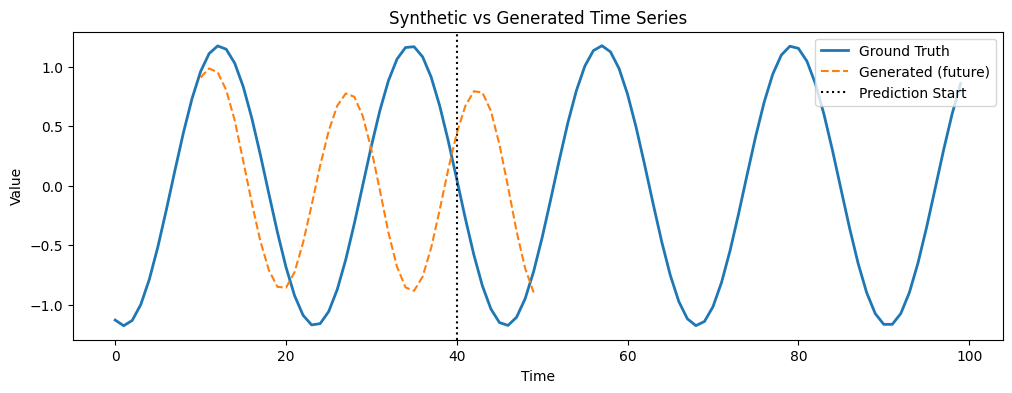

In [93]:
model.eval()

# pick one validation sample
idx = torch.randint(0, val_data.shape[0], (1,)).item()
gt_sequence = val_data[idx].unsqueeze(0).unsqueeze(-1).to(device)  
generated = model.generate(gt_sequence[:, :10,:], 40)
#signal_plot = gt_sequence[:,:50,:].squeeze(0).squeeze(-1).cpu().numpy()
ground_truth = gt_sequence.squeeze(0).squeeze(-1).cpu().numpy()
generated_plot = generated.squeeze(0).squeeze(-1).cpu().numpy()
plt.figure(figsize=(12,4))

plt.plot(ground_truth, label="Ground Truth", linewidth=2)
#plt.plot(generated_plot, label="Generated", linestyle="--")
plt.plot(
    range(10, 10 + len(generated_plot)),
    generated_plot,
    "--",
    label="Generated (future)"
)
plt.axvline(40, color="k", linestyle=":", label="Prediction Start")

plt.legend()
plt.title("Synthetic vs Generated Time Series")
plt.xlabel("Time")
plt.ylabel("Value")
plt.show()

In [148]:
def lam(x, a):
    """
    Intensity function for the NHPP
    """
    return a + np.sin(x)
def sample_poisson_jumps(a, lambda_star, length=1000, seed=None):
    """
    Thinning algorithm for generating a poisson point process signal.
    """
    if seed is not None:
        np.random.seed(seed)
    T = 0.01 * length
    t = 0.0
    n = 0
    arrival_times = []
    while True:
        u = np.random.rand()
        t = t - (1/lambda_star) * np.log(u)

        if t > T:
            break
        u = np.random.rand()
        lambda_t = lam(t, a)
        if u <= lambda_t / lambda_star:
            n += 1
            arrival_times.append(t)
    ts = np.linspace(0, T, length)
    ys = np.searchsorted(arrival_times, ts)
    return ts, ys, arrival_times, T
def sample_poisson_sequences(a, lambda_star, length, num_samples, seed=None):
    samples = []
    for i in range(num_samples):
        ts, ys, arrival_times, T = sample_poisson_jumps(a, lambda_star, length, seed)
        samples.append(ys)
        seed = seed+1
    samples = np.asarray(samples, dtype=np.float32)
    split = int(0.8*num_samples)
    return samples[:split], samples[split:]

In [159]:
KERNELS = [gpflow.kernels.SquaredExponential,
          gpflow.kernels.Matern12,
          gpflow.kernels.Matern32,
          gpflow.kernels.Matern52]
def randomly_sample_kernels(kernels, num_kernels, seed=None):
    if seed is not None:
        np.random.seed(seed)
    sampled_kernels = []
    for i in range(num_kernels):
        kernel = np.random.choice(kernels)()
        lengthscales = np.random.uniform(0.1, 5.0)
        variance = np.random.uniform(0.1, 5.0)
        kernel.lengthscales.assign(lengthscales)
        kernel.variance.assign(variance)
        sampled_kernels.append(kernel)
    return sampled_kernels
def sample_dgp_signal(datapoints, a, b, samples, kernels, num_layers, seed=None):
    if seed is not None:
        np.random.seed(seed)
        tf.random.set_seed(seed)
    X = np.linspace(a, b, datapoints).reshape(-1, 1)
    Z = X.copy()
    M = Z.shape[0]
    gp_layers = []
    D = 1

    ## Construct the each layer with inducing variables
    for i in range(num_layers):
        ind_var = construct_basic_inducing_variables(M, D, D, share_variables=True, z_init=Z.copy())
        kernel = construct_basic_kernel(
            kernels[i],
            output_dim=D,
            share_hyperparams=True)
        gplayer = GPLayer(kernel, ind_var, datapoints, full_cov=True, num_samples=samples, mean_function=gpflow.mean_functions.Zero())
        gp_layers.append(gplayer)
    samples = []
    layer_input = X
    for layer in gp_layers:
        layer_output = layer(layer_input)

        # sample of shape num_samples, length, 1
        sample = tf.convert_to_tensor(layer_output)
        layer_input = sample[0]
        samples.append(sample.numpy())
        
    return np.squeeze(samples[num_layers-1])

def sequences(a, lambda_star, length, kernels, num_layers, num_samples,poisson_seed=None, kernel_seed=None, dgp_seed=None):
    xs, baseline, times, T = sample_poisson_jumps(a, lambda_star, length, poisson_seed)
    kernels = randomly_sample_kernels(kernels, num_layers, kernel_seed)
    samples = baseline[None, :] + sample_dgp_signal(len(xs), 0, T, num_samples, kernels, num_layers, dgp_seed)
    split = int(0.8 * len(samples))
    samples = torch.tensor(
        samples,
        dtype=torch.float32
    )
    print("Data generation completed")
    return baseline, samples[:split], samples[split:]

In [174]:
baseline, train_data1, val_data1 = sequences(2, 3, 300, KERNELS, 1, 500, 1, 1)
train_data1 = torch.FloatTensor(train_data1)
val_data1   = torch.FloatTensor(val_data1)
train_mean = train_data1.mean()
train_std = train_data1.std()

train_data1 = (train_data1 - train_mean) / train_std
val_data1 = (val_data1 - train_mean) / train_std 
# Build datasets
train_dataset1 = DatasetBuilder(
    samples=train_data1,
    seq_len=150,
    stride=None,
    mode="deterministic"
)

val_dataset1 = DatasetBuilder(
    samples=val_data1,
    seq_len=150,
    stride=None,
    mode="deterministic"
)
print(len(val_dataset1))
print(len(train_dataset1))

# Build dataloaders
train_loader1 = DataLoader(
    train_dataset1,
    batch_size=BATCH_SIZE,
    shuffle=False,
    drop_last=True
)

val_loader1 = DataLoader(
    val_dataset1,
    batch_size=BATCH_SIZE,
    shuffle=False,
    drop_last=True
)

Data generation completed
200
800


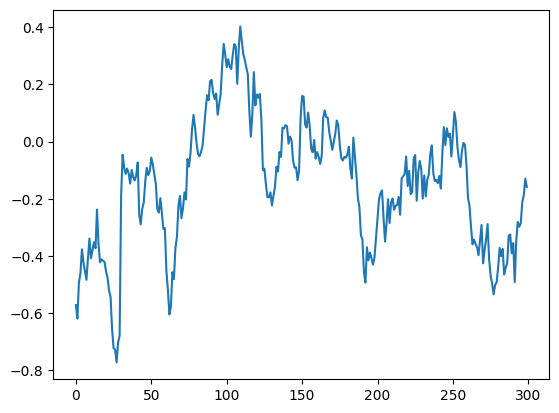

In [175]:
plt.plot(train_data1[0])

In [176]:
train_los, val_los, model = train1(model, train_loader1, val_loader1, epochs=50)

Epoch 1/50 | Train: 0.0563 | Val: 0.0780
Epoch 2/50 | Train: 0.0558 | Val: 0.0783
Epoch 3/50 | Train: 0.0558 | Val: 0.0804
Epoch 4/50 | Train: 0.0559 | Val: 0.0791
Epoch 5/50 | Train: 0.0560 | Val: 0.0803
Epoch 6/50 | Train: 0.0559 | Val: 0.0805
Epoch 7/50 | Train: 0.0558 | Val: 0.0808
Epoch 8/50 | Train: 0.0558 | Val: 0.0793
Epoch 9/50 | Train: 0.0558 | Val: 0.0816
Epoch 10/50 | Train: 0.0557 | Val: 0.0796
Epoch 11/50 | Train: 0.0557 | Val: 0.0804
Epoch 12/50 | Train: 0.0558 | Val: 0.0809
Epoch 13/50 | Train: 0.0557 | Val: 0.0807
Epoch 14/50 | Train: 0.0557 | Val: 0.0797
Epoch 15/50 | Train: 0.0559 | Val: 0.0806
Epoch 16/50 | Train: 0.0557 | Val: 0.0808
Epoch 17/50 | Train: 0.0558 | Val: 0.0810
Epoch 18/50 | Train: 0.0558 | Val: 0.0805
Epoch 19/50 | Train: 0.0558 | Val: 0.0793
Epoch 20/50 | Train: 0.0557 | Val: 0.0829
Epoch 21/50 | Train: 0.0558 | Val: 0.0801
Epoch 22/50 | Train: 0.0556 | Val: 0.0806
Epoch 23/50 | Train: 0.0557 | Val: 0.0804
Epoch 24/50 | Train: 0.0557 | Val: 0.0805
E

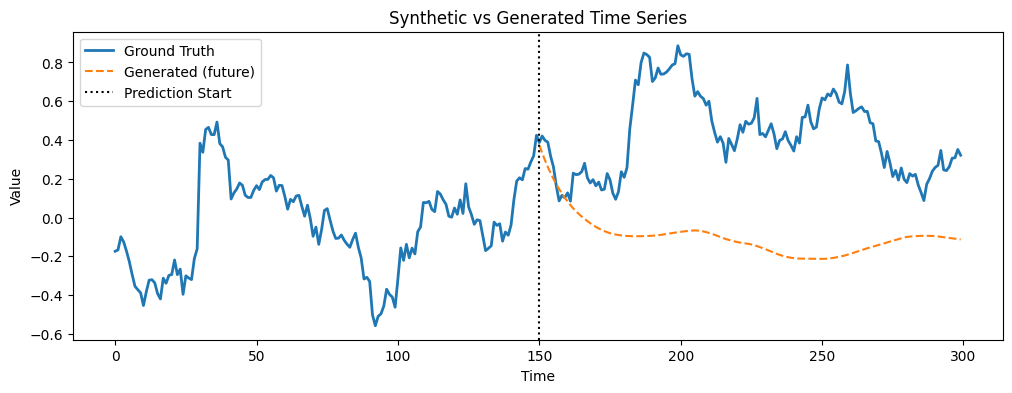

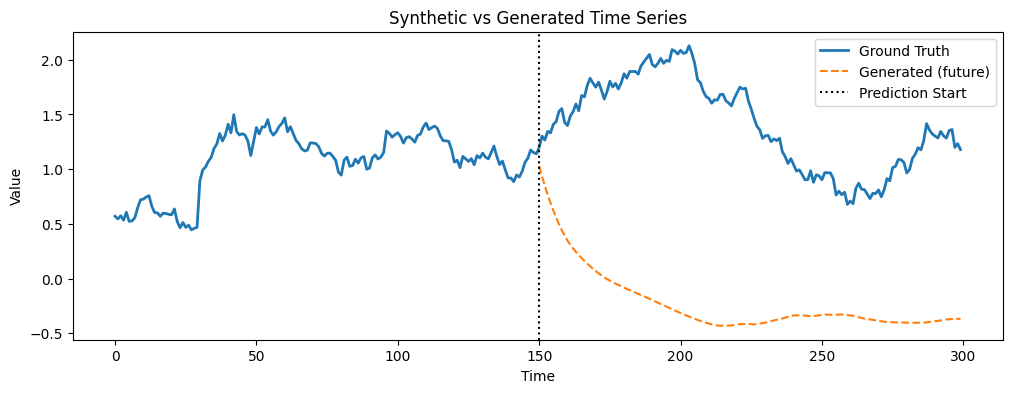

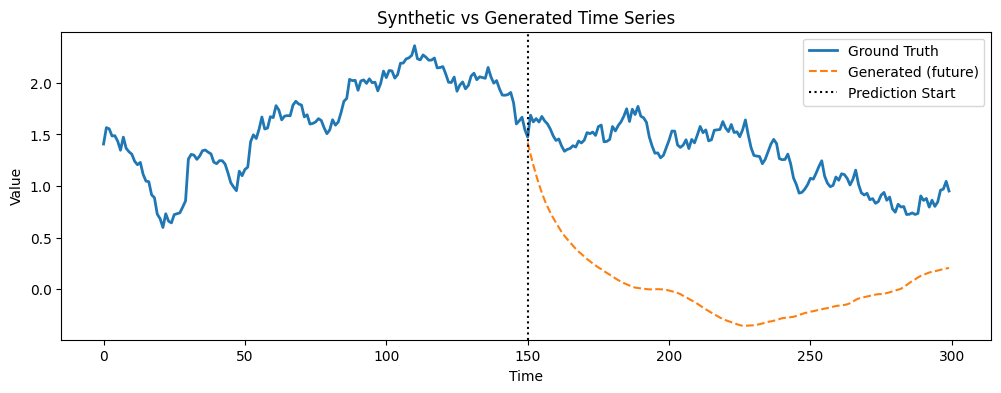

In [184]:
model.eval()

# pick one validation sample
idx = torch.randint(0, val_data1.shape[0], (1,)).item()
gt_sequence = val_data1[idx].unsqueeze(0).unsqueeze(-1).to(device)  
generated = model.generate(gt_sequence[:, :150,:], 150)
#signal_plot = gt_sequence[:,:50,:].squeeze(0).squeeze(-1).cpu().numpy()
ground_truth = gt_sequence.squeeze(0).squeeze(-1).cpu().numpy()
generated_plot = generated.squeeze(0).squeeze(-1).cpu().numpy()
plt.figure(figsize=(12,4))

plt.plot(ground_truth, label="Ground Truth", linewidth=2)
#plt.plot(generated_plot, label="Generated", linestyle="--")
plt.plot(
    range(150, 150 + len(generated_plot)),
    generated_plot,
    "--",
    label="Generated (future)"
)
plt.axvline(150, color="k", linestyle=":", label="Prediction Start")

plt.legend()
plt.title("Synthetic vs Generated Time Series")
plt.xlabel("Time")
plt.ylabel("Value")
plt.show()

model.eval()

# pick one validation sample
idx = torch.randint(0, val_data1.shape[0], (1,)).item()
gt_sequence = val_data1[idx].unsqueeze(0).unsqueeze(-1).to(device)  
generated = model.generate(gt_sequence[:, :150,:], 150)
#signal_plot = gt_sequence[:,:50,:].squeeze(0).squeeze(-1).cpu().numpy()
ground_truth = gt_sequence.squeeze(0).squeeze(-1).cpu().numpy()
generated_plot = generated.squeeze(0).squeeze(-1).cpu().numpy()
plt.figure(figsize=(12,4))

plt.plot(ground_truth, label="Ground Truth", linewidth=2)
#plt.plot(generated_plot, label="Generated", linestyle="--")
plt.plot(
    range(150, 150 + len(generated_plot)),
    generated_plot,
    "--",
    label="Generated (future)"
)
plt.axvline(150, color="k", linestyle=":", label="Prediction Start")

plt.legend()
plt.title("Synthetic vs Generated Time Series")
plt.xlabel("Time")
plt.ylabel("Value")
plt.show()

model.eval()

# pick one validation sample
idx = torch.randint(0, val_data1.shape[0], (1,)).item()
gt_sequence = val_data1[idx].unsqueeze(0).unsqueeze(-1).to(device)  
generated = model.generate(gt_sequence[:, :150,:], 150)
#signal_plot = gt_sequence[:,:50,:].squeeze(0).squeeze(-1).cpu().numpy()
ground_truth = gt_sequence.squeeze(0).squeeze(-1).cpu().numpy()
generated_plot = generated.squeeze(0).squeeze(-1).cpu().numpy()
plt.figure(figsize=(12,4))

plt.plot(ground_truth, label="Ground Truth", linewidth=2)
#plt.plot(generated_plot, label="Generated", linestyle="--")
plt.plot(
    range(150, 150 + len(generated_plot)),
    generated_plot,
    "--",
    label="Generated (future)"
)
plt.axvline(150, color="k", linestyle=":", label="Prediction Start")

plt.legend()
plt.title("Synthetic vs Generated Time Series")
plt.xlabel("Time")
plt.ylabel("Value")
plt.show()